### Compare structural measures across datasets

#### Datasets
- NIMHANS
- QPN
- PPMI

#### Measures
- Cortical thickness (FS)
- Regional volumes (FS)

In [8]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from nilearn import datasets, surface, plotting


In [48]:
projects_dir = f"/home/nikhil/projects/neuroinformatics_tools/" 

nimhans_serb_agg_data_dir = f"{projects_dir}/mr_proc-nimhans_serb/analysis/CT/agg_dfs/SERB/"
nimhans_metal_agg_data_dir = f"{projects_dir}/mr_proc-nimhans_serb/analysis/CT/agg_dfs/METAL/"
qpn_agg_data_dir = f"{projects_dir}/mr_proc-qpn/analysis/CT/agg_dfs/"
ppmi_agg_data_dir = f"{projects_dir}/mr_proc-ppmi/analysis/CT/agg_dfs/"

CT_DKT_csv = "CT_DKT_df.csv"
bilateral_vol_csv = "bilateral_vol_ASEG_df.csv"
global_vol_csv = "global_vol_ASEG_df.csv"

# save dirs
figs_dir = "../figs/population_comparisons"

demo_cols = ["bids_id","age","sex","group","hemi","dataset"]

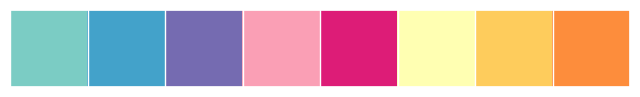

In [49]:
from enum import Enum
class my_colors(Enum):
    NIM_CONTROL = "#7bccc4"
    NIM_SERB_PD = "#43a2ca"
    NIM_METAL_PD = "#756bb1"
    QPN_CONTROL = "#fa9fb5"
    QPN_PD = "#dd1c77"
    PPMI_CONTROL = "#ffffb2"
    PPMI_PRODROMAL = "#fecc5c"
    PPMI_PD = "#fd8d3c"
    
color_list = [my_colors.NIM_CONTROL.value, my_colors.NIM_SERB_PD.value, my_colors.NIM_METAL_PD.value, 
              my_colors.QPN_CONTROL.value, my_colors.QPN_PD.value, 
              my_colors.PPMI_CONTROL.value, my_colors.PPMI_PRODROMAL.value, my_colors.PPMI_PD.value]

palette = sns.color_palette(palette=color_list) #sns.husl_palette()

hue_order = ["NIMHANS_SERB-control", "NIMHANS_SERB-PD", "NIMHANS_METAL-PD", "QPN-control", "QPN-PD", "PPMI-control", "PPMI-prodromal", "PPMI-PD"]

sns.palplot(palette)

### Read data

In [93]:
match_age = False
age_thresh = 63

In [94]:
# NIMHANS (SERB + METAL)
nimhans_serb_CT_DKT_df = pd.read_csv(f"{nimhans_serb_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
nimhans_serb_CT_DKT_df["dataset"] = "NIMHANS_SERB"
n_nimhans_serb_participants = len(nimhans_serb_CT_DKT_df["participant_id"].unique())

nimhans_metal_CT_DKT_df = pd.read_csv(f"{nimhans_metal_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
nimhans_metal_CT_DKT_df["dataset"] = "NIMHANS_METAL"
n_nimhans_metal_participants = len(nimhans_metal_CT_DKT_df["participant_id"].unique())

# QPN
qpn_CT_DKT_df = pd.read_csv(f"{qpn_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
qpn_CT_DKT_df["dataset"] = "QPN"
n_qpn_participants = len(qpn_CT_DKT_df["participant_id"].unique())

# PPMI
ppmi_CT_DKT_df = pd.read_csv(f"{ppmi_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
ppmi_CT_DKT_df["dataset"] = "PPMI"
ppmi_CT_DKT_df["participant_id"] = ppmi_CT_DKT_df["participant_id"].astype(str)
ppmi_CT_DKT_df["bids_id"] = "sub-" + ppmi_CT_DKT_df["participant_id"]

n_ppmi_participants = len(ppmi_CT_DKT_df["participant_id"].unique())

print(f"n_nimhans_participants: {(n_nimhans_serb_participants, n_nimhans_metal_participants)}, n_qpn_participants (all):{n_qpn_participants}, n_ppmi_participants: {n_ppmi_participants}")

if match_age:
    print(f"Matching age < {age_thresh}")
    qpn_CT_DKT_df = qpn_CT_DKT_df[qpn_CT_DKT_df["age"]<age_thresh]
    ppmi_CT_DKT_df = ppmi_CT_DKT_df[ppmi_CT_DKT_df["age"]<age_thresh]

    n_qpn_participants = len(qpn_CT_DKT_df["participant_id"].unique())
    n_ppmi_participants = len(ppmi_CT_DKT_df["participant_id"].unique())

    print(f"n_nimhans_participants: {(n_nimhans_serb_participants, n_nimhans_metal_participants)}, n_qpn_participants (young):{n_qpn_participants}, n_ppmi_participants: {n_ppmi_participants}")

# Concat
CT_DKT_df = pd.concat([nimhans_serb_CT_DKT_df, nimhans_metal_CT_DKT_df, qpn_CT_DKT_df,ppmi_CT_DKT_df], axis=0) #ppmi_CT_DKT_df
CT_DKT_df["ds_group"] = CT_DKT_df["dataset"] + "-" + CT_DKT_df["group"]
print(f"CT_DKT_df shape: {CT_DKT_df.shape}, n_total_participants: {len(CT_DKT_df['participant_id'].unique())}")


## tmp
CT_DKT_df = CT_DKT_df.drop(columns=["participant_id"])

CT_DKT_df.head()

n_nimhans_participants: (86, 66), n_qpn_participants (all):201, n_ppmi_participants: 406
CT_DKT_df shape: (1612, 39), n_total_participants: 759


,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,fusiform,inferiorparietal,inferiortemporal,insula,isthmuscingulate,lateraloccipital,...,superiortemporal,supramarginal,transversetemporal,bids_id,age,sex,group,hemi,dataset,ds_group
0,2.643,2.648,1.866,3.932,3.098,2.638,2.969,3.294,2.312,2.189,...,3.044,2.717,2.386,sub-SERB088,54.0,M,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
1,3.230,2.844,1.941,3.825,2.900,2.479,3.003,3.427,2.308,2.365,...,2.998,2.589,1.971,sub-SERB058,64.0,M,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
2,2.756,2.717,1.997,3.036,2.709,2.457,2.875,3.183,2.388,2.123,...,2.912,2.526,1.875,sub-SERB049,62.0,M,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
3,2.974,2.603,1.819,3.802,2.701,2.399,2.947,3.205,2.468,2.364,...,2.928,2.532,2.250,sub-SERB084,NaN,NaN,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
4,3.015,2.939,1.998,4.177,3.054,2.831,3.403,3.701,2.462,2.382,...,3.118,2.933,2.776,sub-SERB063,56.0,M,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD


### Subsample QPN to match age

In [95]:
CT_DKT_df.groupby(["dataset","group"])["age"].describe()

count       mean        std   min     25%    50%  \
dataset       group                                                         
NIMHANS_METAL PD         118.0  53.644068  10.089790  24.0  46.000  55.00   
NIMHANS_SERB  PD         108.0  55.388889   7.165381  36.0  50.000  56.00   
              control     30.0  52.000000   5.907330  41.0  48.500  53.00   
PPMI          PD         458.0  62.515284   9.174505  38.0  56.000  63.00   
              control    158.0  59.759494  10.946558  31.0  53.000  61.00   
              prodromal  194.0  62.597938   7.942357  42.0  57.000  63.00   
QPN           PD         326.0  64.610429   9.219862  40.9  57.675  64.30   
              control     72.0  64.738889  11.331354  37.7  57.250  66.15   

                            75%   max  
dataset       group                    
NIMHANS_METAL PD         61.000  72.0  
NIMHANS_SERB  PD         61.000  67.0  
              control    56.750  60.0  
PPMI          PD         70.000  82.0  
              control    67.000  81.0  
              prodromal  68.000  84.0  
QPN           PD         70.775  86.1  
              control    71.925  83.0

/home/nikhil/projects/my_venvs/napari/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


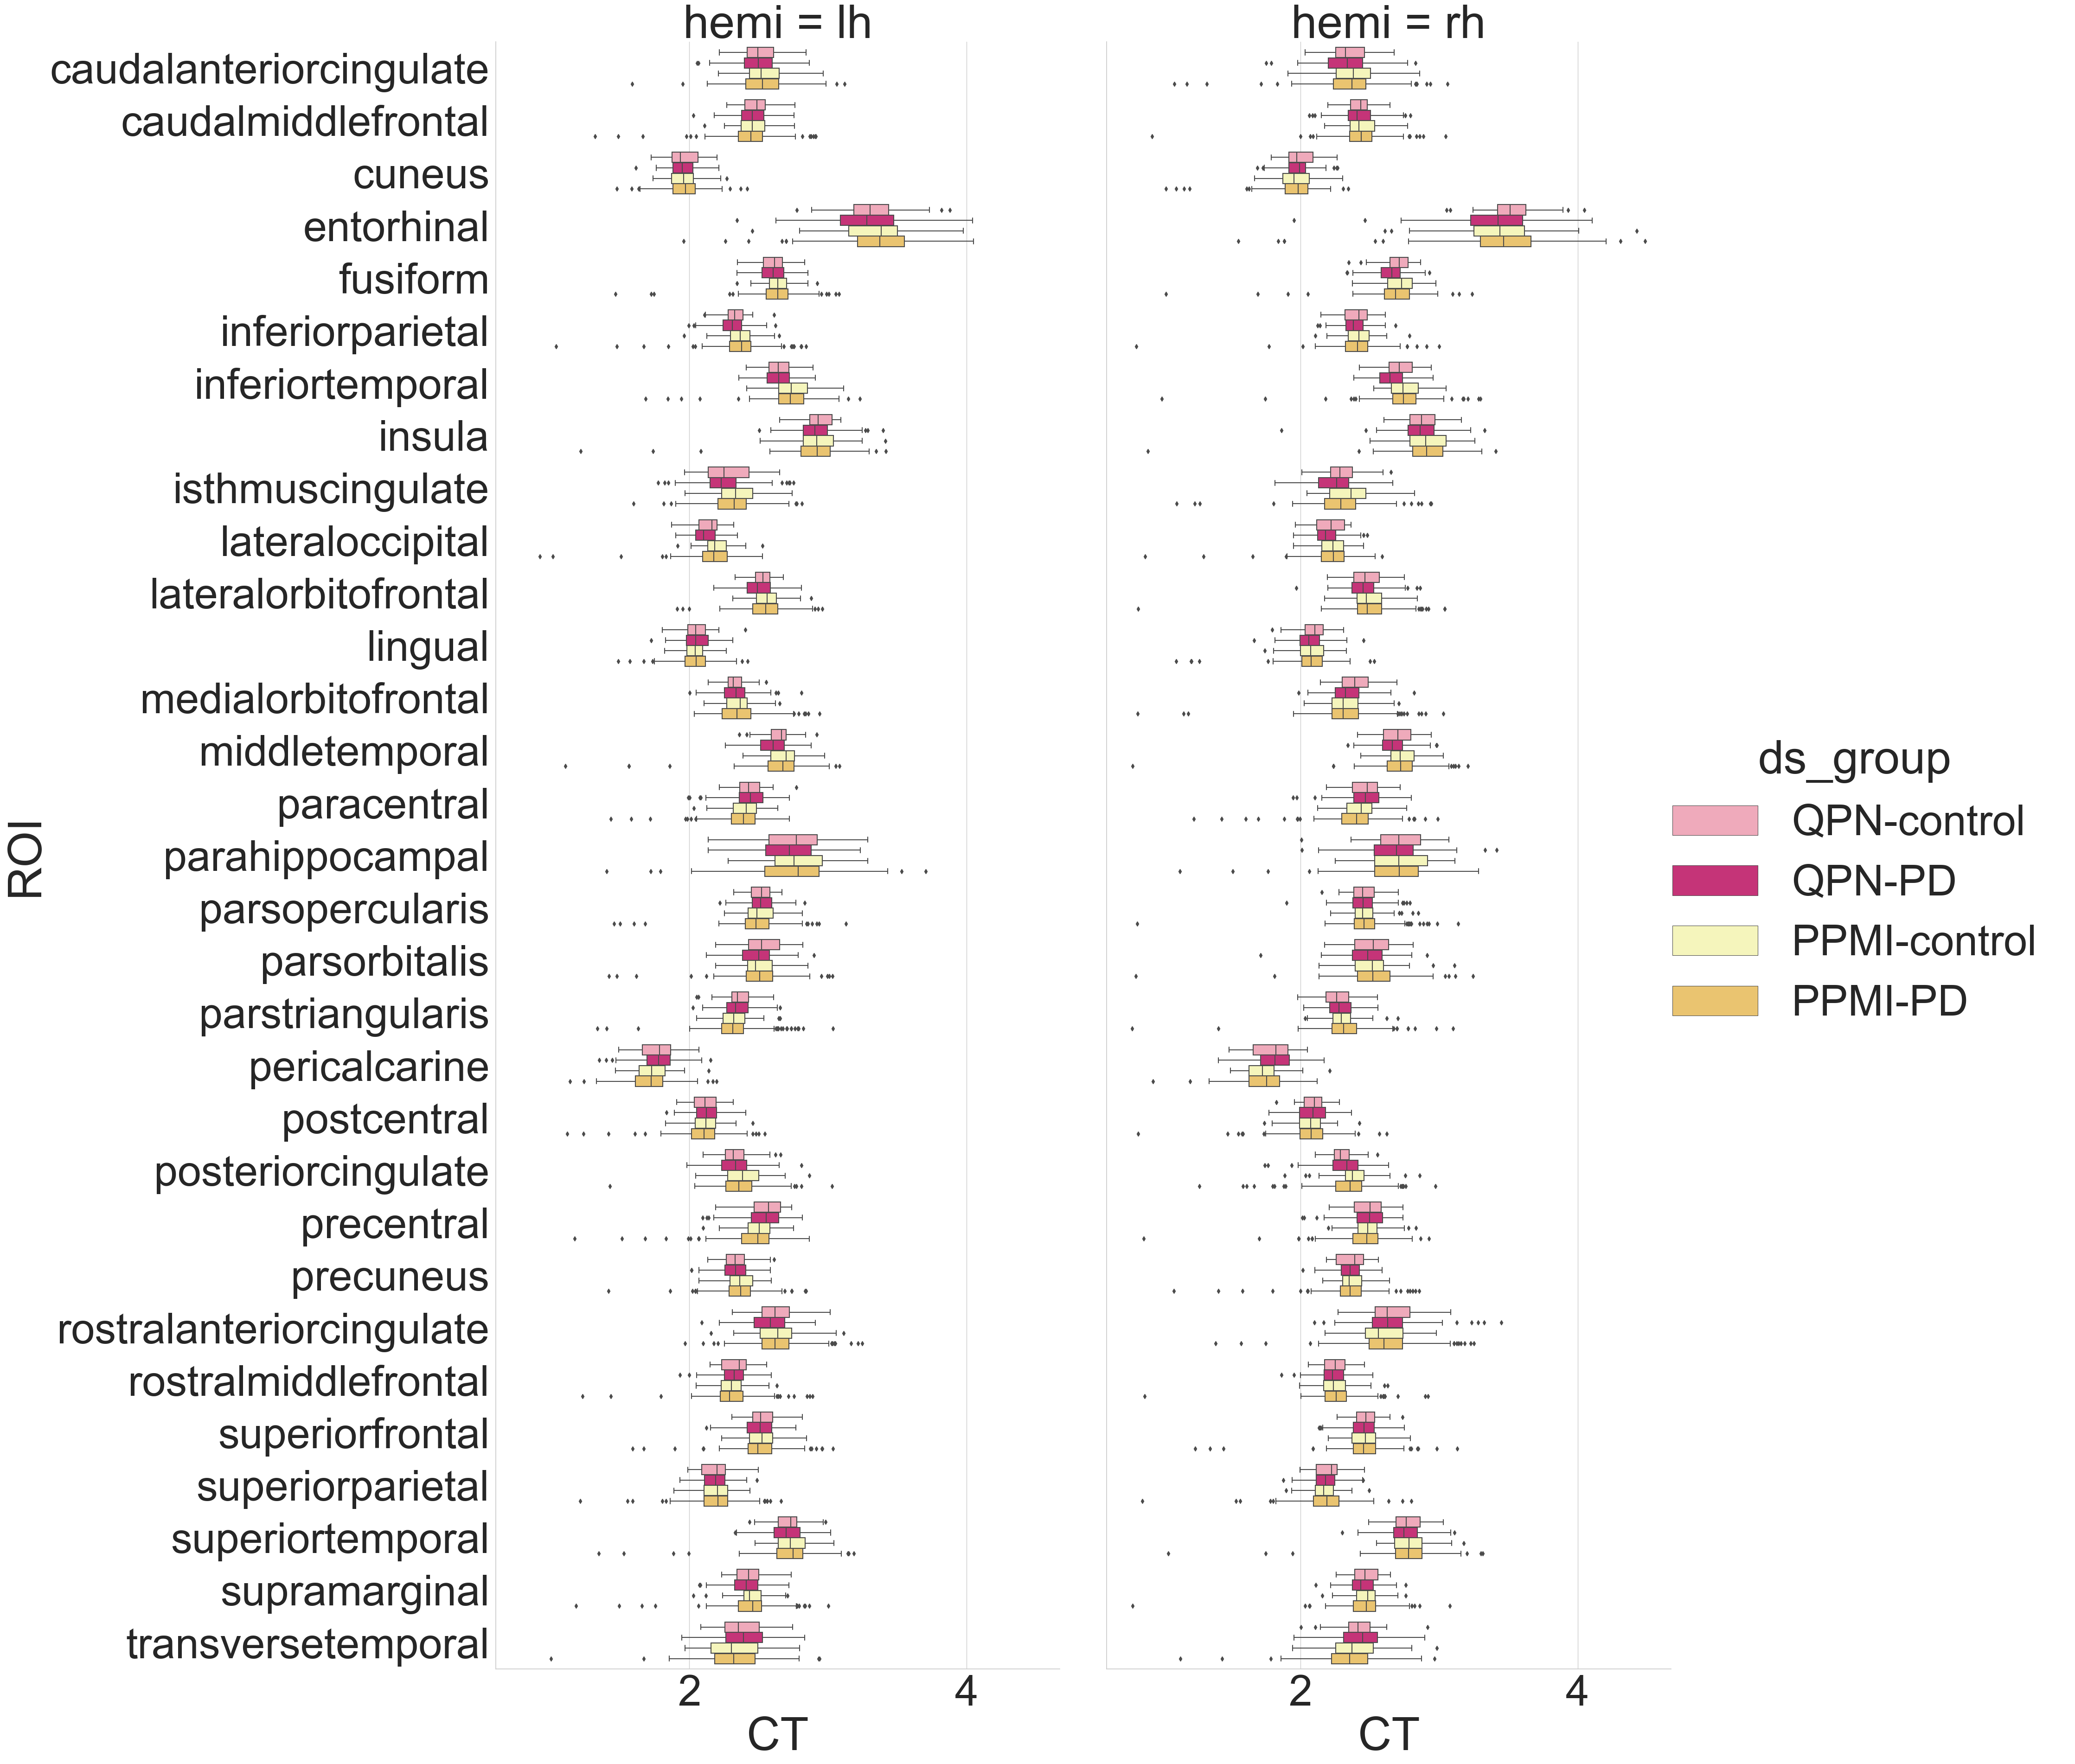

In [96]:
save_fig = False

CT_DKT_df = CT_DKT_df[CT_DKT_df["dataset"].isin(["PPMI", "QPN"])]
CT_DKT_df = CT_DKT_df[CT_DKT_df["group"].isin(["control", "PD"])]

color_list = [my_colors.QPN_CONTROL.value, my_colors.QPN_PD.value, 
              my_colors.PPMI_CONTROL.value, my_colors.PPMI_PRODROMAL.value, my_colors.PPMI_PD.value]

palette = sns.color_palette(palette=color_list) 
hue_order = [ "QPN-control", "QPN-PD", "PPMI-control", "PPMI-PD"] #"PPMI-prodromal", 

CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols + ["ds_group"],
    var_name="ROI", 
    value_name="CT")

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)


sns.set(font_scale=6)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="ROI",x="CT", hue="ds_group", col="hemi",kind="box",palette=palette, hue_order=hue_order, legend=True,
                    data=plot_df, aspect=0.5, height=40)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/DKT.png")

### Aseg bilateral volume

In [97]:
# NIMHANS (SERB + METAL)
nimhans_serb_hemi_ASEG_df = pd.read_csv(f"{nimhans_serb_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_serb_hemi_ASEG_df["dataset"] = "NIMHANS_SERB"
n_nimhans_serb_participants = len(nimhans_serb_hemi_ASEG_df["participant_id"].unique())

nimhans_metal_hemi_ASEG_df = pd.read_csv(f"{nimhans_metal_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_metal_hemi_ASEG_df["dataset"] = "NIMHANS_METAL"
n_nimhans_metal_participants = len(nimhans_metal_hemi_ASEG_df["participant_id"].unique())

# QPN
qpn_hemi_ASEG_df = pd.read_csv(f"{qpn_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
qpn_hemi_ASEG_df["dataset"] = "QPN"
n_qpn_participants = len(qpn_hemi_ASEG_df["participant_id"].unique())

# PPMI
ppmi_hemi_ASEG_df = pd.read_csv(f"{ppmi_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
ppmi_hemi_ASEG_df["dataset"] = "PPMI"
n_ppmi_participants = len(ppmi_hemi_ASEG_df["participant_id"].unique())

print(f"n_nimhans_participants: {(n_nimhans_serb_participants,n_nimhans_metal_participants)}, n_qpn_participants:{n_qpn_participants}")

if match_age:
    print(f"Matching age < {age_thresh}")

    ppmi_hemi_ASEG_df = ppmi_hemi_ASEG_df[ppmi_hemi_ASEG_df["age"]<age_thresh]
    n_ppmi_participants = len(ppmi_hemi_ASEG_df["participant_id"].unique())

    qpn_hemi_ASEG_df = qpn_hemi_ASEG_df[qpn_hemi_ASEG_df["age"]<age_thresh]
    n_qpn_participants = len(qpn_hemi_ASEG_df["participant_id"].unique())
    print(f"n_nimhans_participants: {(n_nimhans_serb_participants,n_nimhans_metal_participants)}, n_qpn_participants:{n_qpn_participants}, n_ppmi_participants: {n_ppmi_participants}")


# Concat
hemi_ASEG_df = pd.concat([nimhans_serb_hemi_ASEG_df, nimhans_metal_hemi_ASEG_df, qpn_hemi_ASEG_df, ppmi_hemi_ASEG_df], axis=0)
hemi_ASEG_df["ds_group"] = hemi_ASEG_df["dataset"] + "-" + hemi_ASEG_df["group"]
print(f"hemi_ASEG_df shape: {hemi_ASEG_df.shape}")

## tmp
hemi_ASEG_df = hemi_ASEG_df.drop(columns=["participant_id"])

hemi_ASEG_df.head()

n_nimhans_participants: (86, 66), n_qpn_participants:201
hemi_ASEG_df shape: (1612, 22)


,Cerebellum-White-Matter,Amygdala,Lateral-Ventricle,Cerebellum-Cortex,Putamen,Thalamus-Proper,vessel,choroid-plexus,Caudate,Hippocampus,...,Inf-Lat-Vent,Accumbens-area,Pallidum,bids_id,age,sex,group,hemi,dataset,ds_group
0,14102.900391,1659.300049,9170.500000,49608.800781,4586.500000,6357.399902,125.800003,684.400024,3355.899902,3580.399902,...,305.000000,394.600006,2000.800049,sub-SERB088,54.0,M,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
1,12641.299805,1223.000000,7667.399902,42569.199219,3512.899902,5716.799805,24.000000,623.900024,2633.600098,3400.500000,...,499.500000,177.800003,1638.900024,sub-SERB058,64.0,M,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
2,20009.800781,1357.099976,16945.599609,50561.199219,4779.700195,6195.899902,29.299999,1066.400024,3021.699951,3541.500000,...,773.900024,431.500000,2295.199951,sub-SERB049,62.0,M,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
3,10348.900391,1344.599976,10064.700195,41859.898438,2910.699951,5412.100098,13.900000,818.299988,1672.599976,3827.000000,...,195.899994,349.500000,1645.500000,sub-SERB084,NaN,NaN,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD
4,11251.599609,1442.900024,8531.599609,46157.500000,3410.100098,5824.899902,40.000000,592.799988,2352.199951,3377.800049,...,580.599976,403.799988,1618.900024,sub-SERB063,56.0,M,PD,lh,NIMHANS_SERB,NIMHANS_SERB-PD


/home/nikhil/projects/my_venvs/napari/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


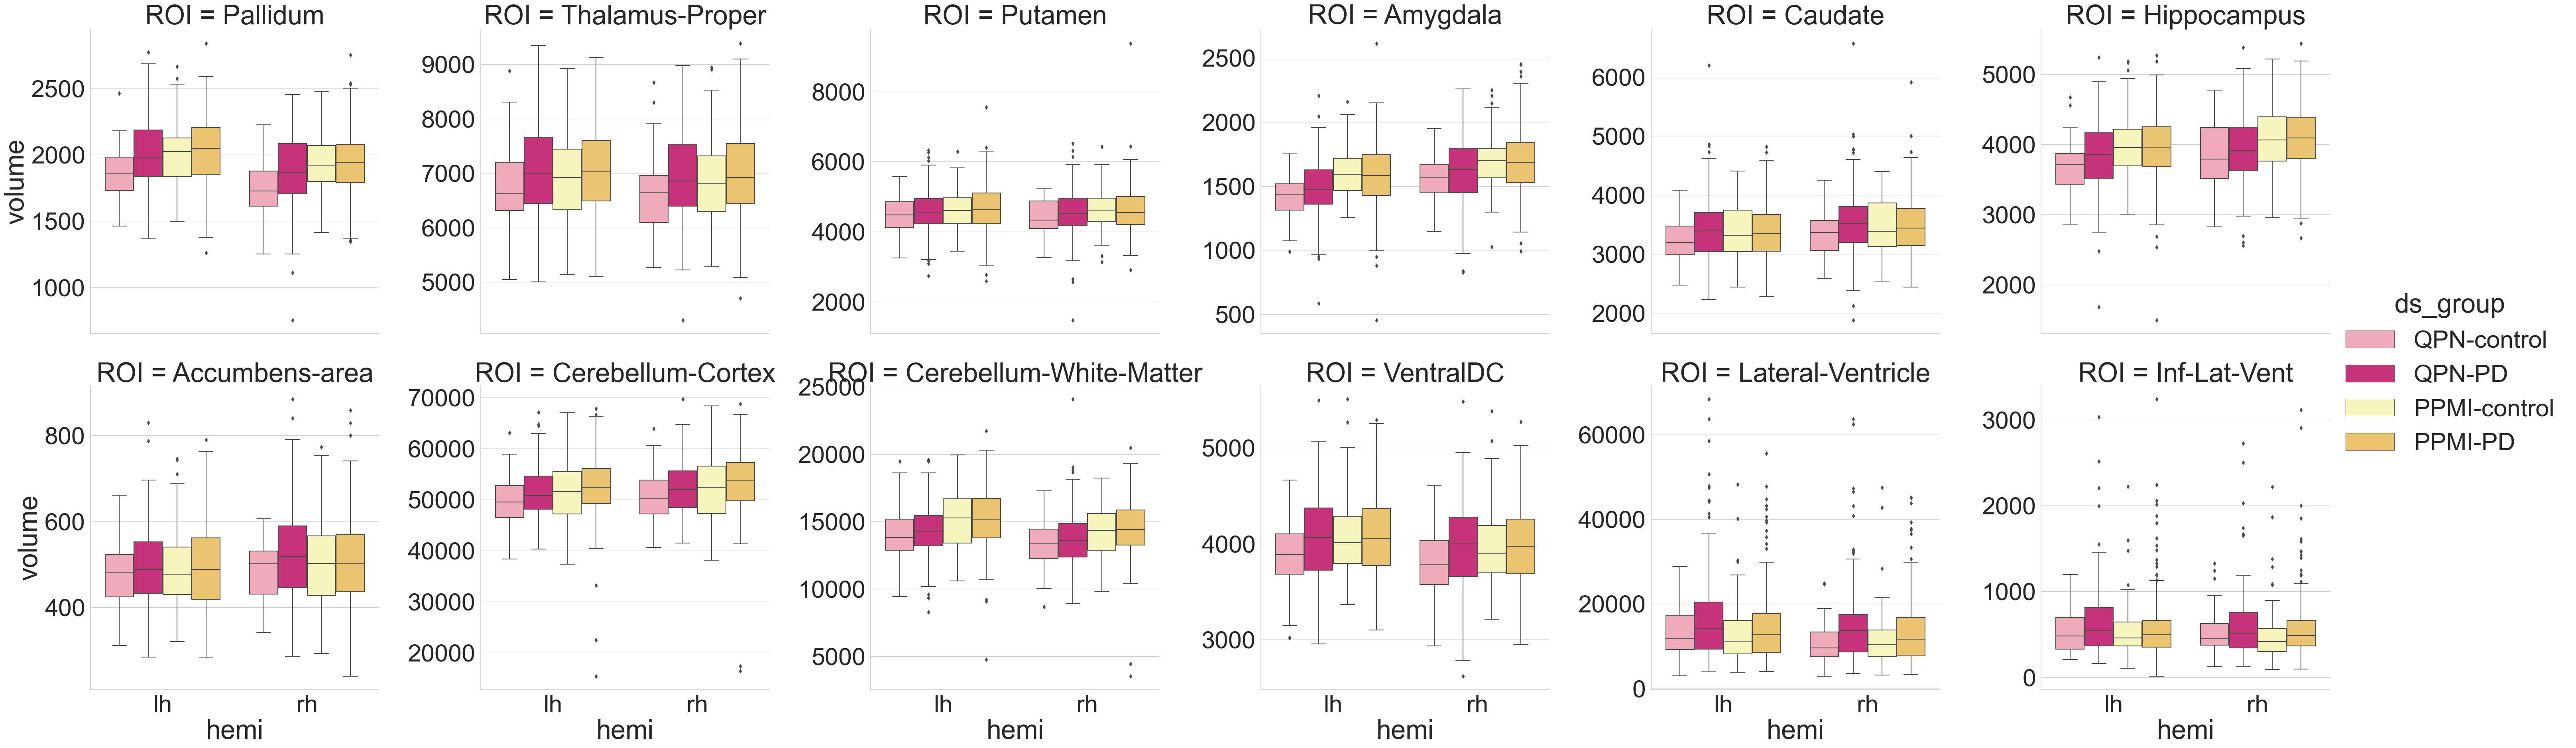

In [98]:
save_fig = False

hemi_ASEG_df = hemi_ASEG_df[hemi_ASEG_df["dataset"].isin(["PPMI", "QPN"])]
hemi_ASEG_df = hemi_ASEG_df[hemi_ASEG_df["group"].isin(["control", "PD"])]

vol_ASEG_df_melt = hemi_ASEG_df.melt(
    id_vars=demo_cols + ["ds_group"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = vol_ASEG_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)
hemi_roi_list = ['Pallidum', 'Thalamus-Proper', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'Accumbens-area', 
                'Cerebellum-Cortex','Cerebellum-White-Matter','VentralDC', 'Lateral-Ventricle','Inf-Lat-Vent']

sns.set(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="ds_group", col="ROI",kind="box", col_wrap=6, col_order=hemi_roi_list, hue_order=hue_order,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False, legend=True)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_hemi.png")

### Global volumes

In [99]:
# NIMHANS (SERB + METAL)
nimhans_serb_global_ASEG_df = pd.read_csv(f"{nimhans_serb_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_serb_global_ASEG_df["dataset"] = "NIMHANS_SERB"
n_nimhans_serb_participants = len(nimhans_serb_global_ASEG_df["participant_id"].unique())

nimhans_metal_global_ASEG_df = pd.read_csv(f"{nimhans_metal_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_metal_global_ASEG_df["dataset"] = "NIMHANS_METAL"
n_nimhans_metal_participants = len(nimhans_metal_global_ASEG_df["participant_id"].unique())

# QPN
qpn_global_ASEG_df = pd.read_csv(f"{qpn_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
qpn_global_ASEG_df["dataset"] = "QPN"
n_qpn_participants = len(qpn_global_ASEG_df["participant_id"].unique())

# PPMI
ppmi_global_ASEG_df = pd.read_csv(f"{ppmi_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
ppmi_global_ASEG_df["dataset"] = "PPMI"
n_ppmi_participants = len(ppmi_global_ASEG_df["participant_id"].unique())

print(f"n_nimhans_participants: {(n_nimhans_serb_participants, n_nimhans_metal_participants)}, n_qpn_participants:{n_qpn_participants}")

if match_age:
    print(f"Matching age < {age_thresh}")

    ppmi_global_ASEG_df = ppmi_global_ASEG_df[ppmi_global_ASEG_df["age"]<age_thresh]
    n_ppmi_participants = len(ppmi_global_ASEG_df["participant_id"].unique())

    qpn_global_ASEG_df = qpn_global_ASEG_df[qpn_global_ASEG_df["age"]<age_thresh]
    n_qpn_participants = len(qpn_global_ASEG_df["participant_id"].unique())
    print(f"n_nimhans_participants: {(n_nimhans_serb_participants, n_nimhans_metal_participants)}, n_qpn_participant:{n_qpn_participants}, n_ppmi_participants: {n_ppmi_participants}")

# Concat
global_vol_ASEG_df = pd.concat([nimhans_serb_global_ASEG_df, nimhans_metal_global_ASEG_df, qpn_global_ASEG_df, ppmi_global_ASEG_df], axis=0)
global_vol_ASEG_df["ds_group"] = global_vol_ASEG_df["dataset"] + "-" + global_vol_ASEG_df["group"]
print(f"global_vol_ASEG_df shape: {global_vol_ASEG_df.shape}")

## tmp
qpn_global_ASEG_df = qpn_global_ASEG_df.drop(columns=["participant_id"])

qpn_global_ASEG_df.head()

n_nimhans_participants: (86, 66), n_qpn_participants:201
global_vol_ASEG_df shape: (806, 24)


,SupraTentorial,TotalGray,BrainSeg,BrainSegNotVent,SupraTentorialNotVent,WM-hypointensities,EstimatedTotalIntraCranial,5th-Ventricle,4th-Ventricle,3rd-Ventricle,...,SubCortGray,Optic-Chiasm,BrainSegNotVentSurf,non-WM-hypointensities,bids_id,age,sex,group,hemi,dataset
0,8.194661e+05,500234.186085,939504.0,915180.0,7.993121e+05,9281.700195,1.356671e+06,0.0,1549.000000,1581.400024,...,47054.0,155.899994,9.146731e+05,15.3,sub-PD01709,69.3,F,PD,global,QPN
1,1.280777e+06,779374.258473,1457215.0,1423757.0,1.253226e+06,1731.000000,1.932300e+06,0.0,2606.399902,1887.400024,...,70481.0,212.199997,1.423165e+06,0.0,sub-PD00215,48.5,M,PD,global,QPN
2,1.168116e+06,634722.610129,1321813.0,1192748.0,1.046529e+06,15173.200195,1.832187e+06,0.0,3345.699951,2653.300049,...,60290.0,157.199997,1.191393e+06,0.0,sub-PD01295,74.8,M,PD,global,QPN
3,1.002630e+06,584506.867513,1114040.0,1077374.0,9.700843e+05,3868.699951,1.492908e+06,0.0,1684.199951,1175.000000,...,56202.0,121.800003,1.076999e+06,2.5,sub-PD01398,61.9,F,PD,global,QPN
4,7.560226e+05,506704.879814,861734.0,843682.0,7.411936e+05,1220.400024,1.146054e+06,0.0,1408.300049,1069.199951,...,44332.0,114.099998,8.435806e+05,0.0,sub-PD00849,62.2,F,PD,global,QPN


/home/nikhil/projects/my_venvs/napari/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


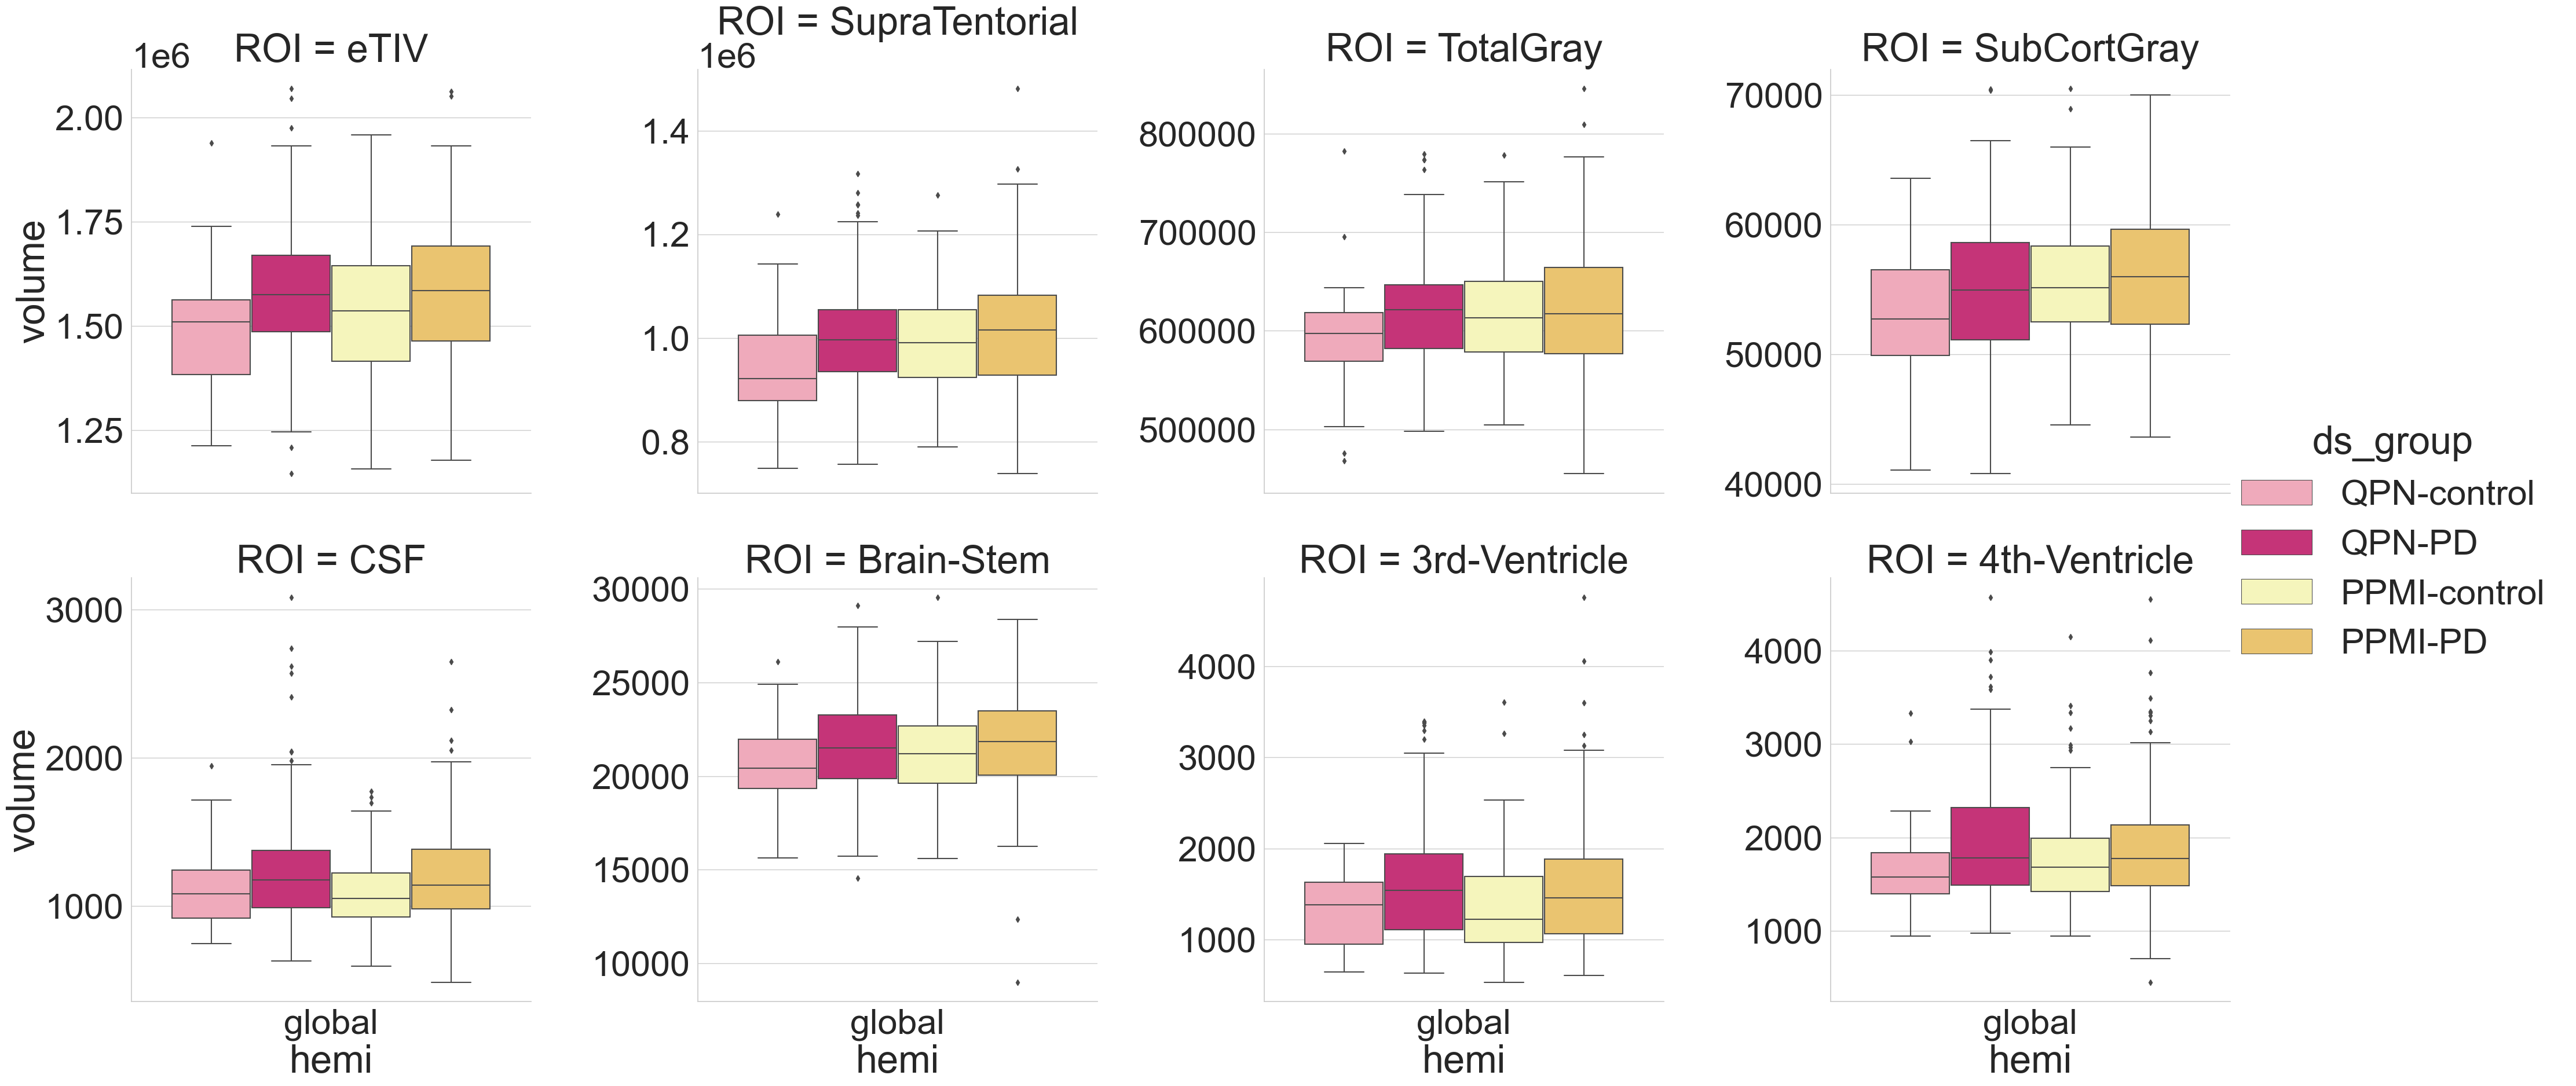

In [100]:
save_fig = False

global_vol_ASEG_df = global_vol_ASEG_df[global_vol_ASEG_df["dataset"].isin(["PPMI", "QPN"])]
global_vol_ASEG_df = global_vol_ASEG_df[global_vol_ASEG_df["group"].isin(["control", "PD"])]

global_vol_ASEG_df = global_vol_ASEG_df.rename(columns={"EstimatedTotalIntraCranial":"eTIV"})

global_vol_ASEG_df_melt = global_vol_ASEG_df.melt(
    id_vars=demo_cols + ["ds_group"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = global_vol_ASEG_df_melt.copy()

global_roi_list = ["eTIV", "SupraTentorial", "TotalGray", "SubCortGray", 
                    "CSF","Brain-Stem","3rd-Ventricle","4th-Ventricle"]
plot_df = plot_df[plot_df["ROI"].isin(global_roi_list)]

sns.set(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="ds_group", col="ROI", kind="box", col_wrap=4, col_order=global_roi_list, hue_order=hue_order,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False, legend=True)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_global.png")

### Demographics

In [101]:
demo_df = global_vol_ASEG_df[demo_cols].copy()
demo_df.groupby(["dataset","group"]).count()

bids_id  age  sex  hemi
dataset group                           
PPMI    PD             0  229  229   229
        control        0   79   79    79
QPN     PD           163  163  163   163
        control       37   36   37    37

In [102]:
demo_df.groupby(["dataset","group"])["age"].describe()

count       mean        std   min    25%    50%     75%   max
dataset group                                                                 
PPMI    PD       229.0  62.515284   9.184559  38.0  56.00  63.00  70.000  82.0
        control   79.0  59.759494  10.981587  31.0  53.00  61.00  67.000  81.0
QPN     PD       163.0  64.610429   9.234079  40.9  57.75  64.30  70.750  86.1
        control   36.0  64.738889  11.412006  37.7  57.25  66.15  71.925  83.0